# Analysis of Transfer Events of a Token Contract

The Aim of this exercise is to query an ethereum node and find out all the transfer events from any `starting block` to an `ending_block`. We consider not a very large `block_range`(`starting_block` - `ending_block`) as we can query at max `10,000` events in a single request to the node.

Here we write the code such that this should be able to take the contract address of any token and return the analysis. All we need to do is change the `contract_address` variable and the rest should be the same.

## Setup

In [ ]:
!pip install web3==5.30.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.2/501.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of eth-utils to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.0 MB/s eta 0:00:00
  Created wheel for websockets: filename=websockets-9.1-cp310-cp310-linu

In [ ]:
## Import Libraries

from web3 import Web3
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Set up Infura Node

import getpass

# Infura API setup
API_KEY = getpass.getpass()
infura_url = f"https://mainnet.infura.io/v3/{API_KEY}"
web3 = Web3(Web3.HTTPProvider(infura_url))

··········


## Parse Token Details and Transfer Events from Token Contract

In [ ]:
# Token contract address
contract_address = "0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b" ## Axie Infinity Contract

# Contract ABI for Transfer Events, Token Decimals and Contract Name
contract_abi = [
    {
        "anonymous": False,
        "inputs": [
            {
                "indexed": True,
                "internalType": "address",
                "name": "_from",
                "type": "address"
            },
            {
                "indexed": True,
                "internalType": "address",
                "name": "_to",
                "type": "address"
            },
            {
                "indexed": False,
                "internalType": "uint256",
                "name": "_value",
                "type": "uint256"
            }
        ],
        "name": "Transfer",
        "type": "event"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "decimals",
        "outputs": [
            {
                "internalType": "uint8",
                "name": "",
                "type": "uint8"
            }
        ],
        "payable": False,
        "stateMutability": "view",
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "name",
        "outputs": [
            {
                "internalType": "string",
                "name": "",
                "type": "string"
            }
        ],
        "payable": False,
        "stateMutability": "view",
        "type": "function"
    }
]

# Set the range of blocks to scan for events

from_block = 17351837 # Replace with desired starting block
to_block = 17361837 # Replace with  desired ending block

# Set up contract instance
contract = web3.eth.contract(address=contract_address, abi=contract_abi)

# Get the name of the contract
name = contract.functions.name().call()

# Get the no of decimals for the token
decimals = contract.functions.decimals().call()

# Get Transfer events
events = contract.events.Transfer.getLogs(fromBlock=from_block, toBlock=to_block)

In [ ]:
def find_block_timestamp(blockNumber):
    '''Finds block date for a given block number. Only an estimation data as caclulating exact block date
    from node requires multiple requests. 
    
    Using block number 17351837(https://etherscan.io/block/17351837) for reference.
    
    Block timestamp for block 17351837 = 1685207(`May-27-2023 05:19:47 PM +UTC`)
    
    Hence, Block timestamp for block x = AVG_BLOCK_TIME * (blockNumber - 17351837) + 1685207
    '''
    
    AVG_BLOCK_TIME = 12
    return pd.to_datetime(AVG_BLOCK_TIME * (blockNumber - 17351837) + 1685207987, unit='s').date()

find_block_timestamp(17351837)

datetime.date(2023, 5, 27)

In [ ]:
events_pd = pd.DataFrame(events)

def parse_args(row):
    row['from_address'] = row['args'].get('_from')
    row['to_address'] = row['args'].get('_to')
    row['value'] = int(row['args'].get('_value'))/pow(10,decimals)
    row['transactionHash'] = row['transactionHash'].hex()
    row['blockHash'] = row['blockHash'].hex()
    row['blockDate'] = find_block_timestamp(row['blockNumber'])
    return row

events_pd = events_pd.apply(parse_args, axis=1)
events_pd

,address,args,blockHash,blockNumber,event,logIndex,transactionHash,transactionIndex,from_address,to_address,value,blockDate
0,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x1d8e67b4280fcec25459c28ec10307c4bd515fc57a3e...,17351940,Transfer,89,0xc61f1aaf4ed1666ad7bdaa0b024708d28a4ebf1f84d9...,35,0x21a31Ee1afC51d94C2eFcCAa2092aD1028285549,0xe3776301A5d6b8f0Df0c1ad03Fff6D869acFB6E1,7.117723e+00,2023-05-27
1,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x85d58dcae12cac6459711515f2e911ed1846568988ca...,17351946,Transfer,186,0xe808403b1ed0a3e84857ca6720d0e2e5385cd8eec50c...,91,0xe3776301A5d6b8f0Df0c1ad03Fff6D869acFB6E1,0xe9BB903eB69972294686AEE93C1ed8749eC372Ad,7.117723e+00,2023-05-27
2,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x3680cf34036047385a1202105a8212203b4d86b06be0...,17352004,Transfer,107,0xca5e7cb464bfa688c9ed9416dd242a32192fd9af3ba6...,41,0xDFd5293D8e347dFe59E90eFd55b2956a1343963d,0xF99d57b47F4938B1609Db4ab482F9AF7EE5210FA,3.211600e+02,2023-05-27
3,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x0c122e2b70c25b38eb53d88335523cf9b1a1560ead83...,17352020,Transfer,210,0x183207da4df9c6746d1d3e6257f051528bd95eee632d...,97,0x946eF598032d63368E131E43ef57b805cf60D977,0x74de5d4FCbf63E00296fd95d33236B9794016631,4.058686e+00,2023-05-27
4,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x0c122e2b70c25b38eb53d88335523cf9b1a1560ead83...,17352020,Transfer,211,0x183207da4df9c6746d1d3e6257f051528bd95eee632d...,97,0x74de5d4FCbf63E00296fd95d33236B9794016631,0x0C365789DbBb94A29F8720dc465554c587e897dB,4.058686e+00,2023-05-27
...,...,...,...,...,...,...,...,...,...,...,...,...
313,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x343478d3e2892b0fc75ca0fb5d6ab5cb88cf3310c475...,17361831,Transfer,137,0x545bcaefebecf1cccfe42bccfc49f76f46d06fd304dd...,28,0xA98705506BA10d28227D5ae1eF48E764773B83bB,0x74de5d4FCbf63E00296fd95d33236B9794016631,8.051202e+01,2023-05-29
314,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x343478d3e2892b0fc75ca0fb5d6ab5cb88cf3310c475...,17361831,Transfer,138,0x545bcaefebecf1cccfe42bccfc49f76f46d06fd304dd...,28,0x74de5d4FCbf63E00296fd95d33236B9794016631,0xA69babEF1cA67A37Ffaf7a485DfFF3382056e78C,8.051202e+01,2023-05-29
315,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0x343478d3e2892b0fc75ca0fb5d6ab5cb88cf3310c475...,17361831,Transfer,143,0x545bcaefebecf1cccfe42bccfc49f76f46d06fd304dd...,28,0x74de5d4FCbf63E00296fd95d33236B9794016631,0xA98705506BA10d28227D5ae1eF48E764773B83bB,8.192000e-15,2023-05-29
316,0xBB0E17EF65F82Ab018d8EDd776e8DD940327B28b,"(_from, _to, _value)",0xcd6066800bc3c8a14728ffb6650b06123bfd006e1911...,17361837,Transfer,204,0xd89af1d48659955d0c26317ded8e3bd1bf3e18b2015d...,145,0xe6026F60efc3D0e714f1B89c596aA484fFBd25C8,0x28C6c06298d514Db089934071355E5743bf21d60,6.000000e+03,2023-05-29


## Some basic EDA on Daily Transfer Events

### Plots on Daily Transaction Count and Transaction Values

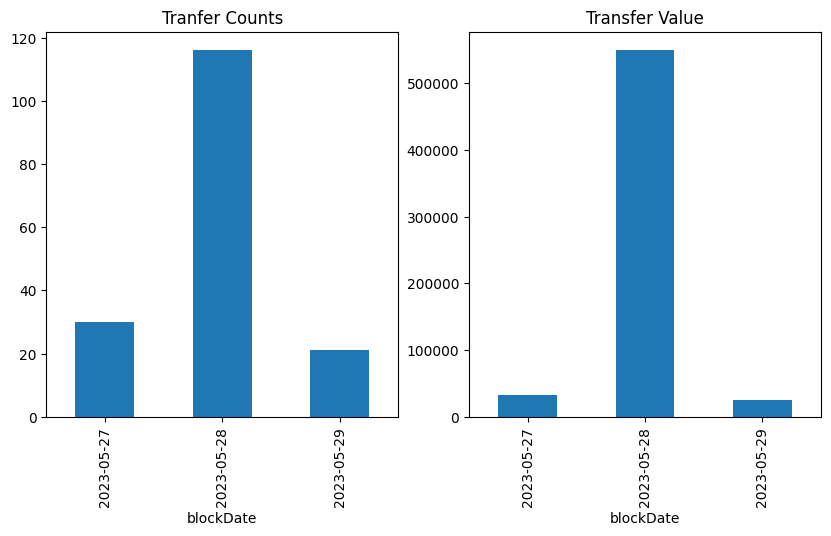

In [ ]:
events_agg_by_date = events_pd.groupby('blockDate')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

plt.title(f'Daily Aggregated plots for \ntoken: {name}, \naddress: {contract_address}')

events_agg_by_date.transactionIndex.nunique().plot.bar(ax = ax1)
ax1.set_title(f'Tranfer Counts')

events_agg_by_date.value.sum().plot.bar(ax = ax2)
ax2.set_title(f'Transfer Value')

plt.show()

## Some basic EDA on Events aggregated by user

In [ ]:
tokens_sent_per_user = events_pd.groupby('from_address').value.sum().reset_index().rename(
    columns={'from_address':'address'}
)
tokens_received_per_user = events_pd.groupby('to_address').value.sum().reset_index().rename(
    columns={'to_address':'address'}
) 

events_agg_by_address = pd.merge(
    tokens_sent_per_user, 
    tokens_received_per_user, 
    how='outer', 
    on='address', 
    suffixes=['_sent','_received']
).fillna(0)

events_agg_by_address['balance'] = events_agg_by_address['value_received'] - events_agg_by_address['value_sent'] 

### Top 5 balance holders

In [ ]:
top_balance_holders = events_agg_by_address.sort_values('balance', ascending=False).head()
display(top_balance_holders)

,address,value_sent,value_received,balance
213,0xF977814e90dA44bFA03b6295A0616a897441aceC,0.00000,277911.107000,277911.107000
60,0x6cC5F688a315f3dC28A7781717a9A798a59fDA7b,10.00000,51764.301680,51754.301680
158,0x242Aaf76c3C27b5873fA12ba63e09654d86cd88a,0.00000,12000.000000,12000.000000
190,0x89E1e8C3e2c934e4a72D419fe8C8818143Aa3822,0.00000,10402.744554,10402.744554
138,0xf16E9B0D03470827A95CDfd0Cb8a8A3b46969B91,787.09576,9330.253842,8543.158082


### Average balance per token holder

In [ ]:
print("Average Value sent per user: ", np.mean(events_agg_by_address['value_sent']))

Average Value sent per user:  2667.584031958503
